In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("rakibuleceruet/drowsiness-prediction-dataset")

# print("Path to dataset files:", path)

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("adinishad/prediction-images")

# print("Path to dataset files:", path)

c:\Work\ProjectFatigueAnalysis\testVenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.18M/1.18M [00:00<00:00, 1.76MB/s]

Extracting files...
Path to dataset files: C:\Users\lamp_\.cache\kagglehub\datasets\adinishad\prediction-images\versions\9


In [29]:

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp
 
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates
 


In [30]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 
 
# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))
 
# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)
 
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [31]:
direc="../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages"
os.makedirs(direc + '/Fatigue Subjects')
os.makedirs(direc +'/Active Subjects')


FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: '../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages/Fatigue Subjects'

In [40]:

IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 
     
     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
     
    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
 
    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, 
        circle_radius=ts_circle_radius, 
        color=(255, 255, 255)
    )

 
    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
 
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark
 
    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
    if cat=='Fatigue Subjects':
        cv2.imwrite(str('../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages/Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages/Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE)) 
    return resized_array

In [41]:
imgH, imgW, _=0,0,0 
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
                            
     # Running inference using static_image_mode 
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:  
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [42]:
def face_for_yawn(direc="../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages", face_cas_path="../datasets/adinishad/prediction-images/versions/9/haarcascade_frontalface_default.xml"):

    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [39]:
dir_path = r'../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages/Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
4560


In [43]:
dir_path = r'../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages/Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
8148


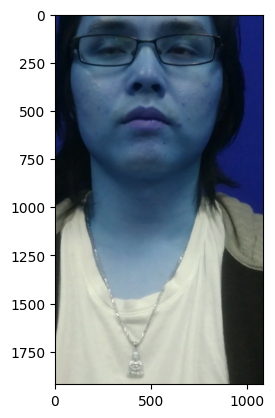

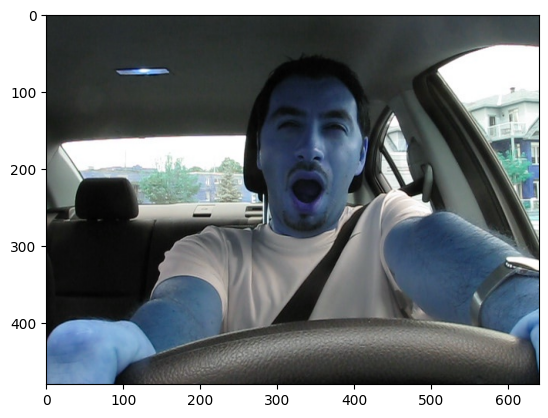

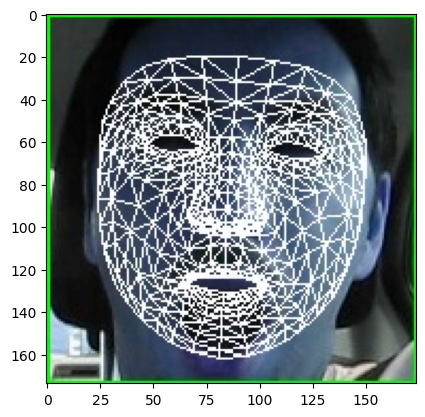

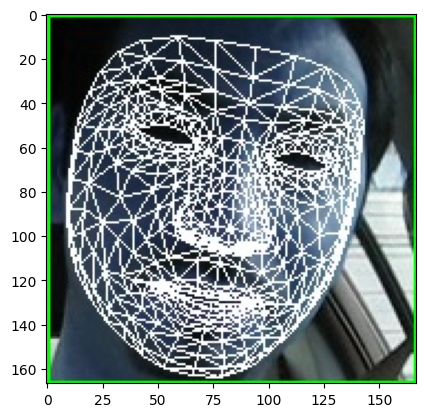

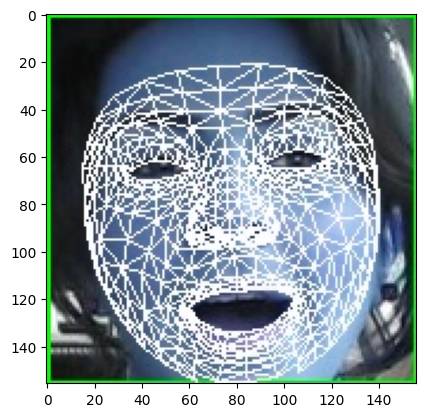

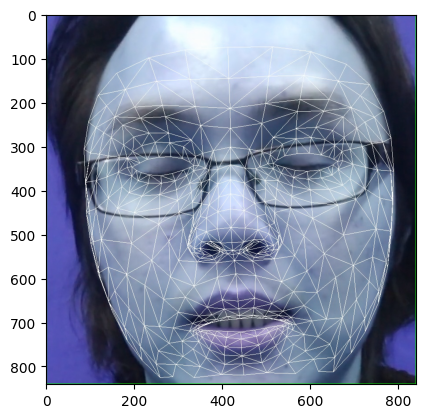

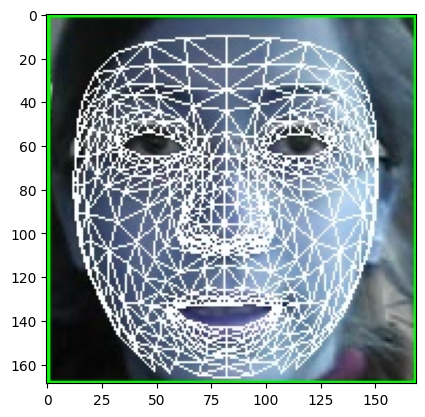

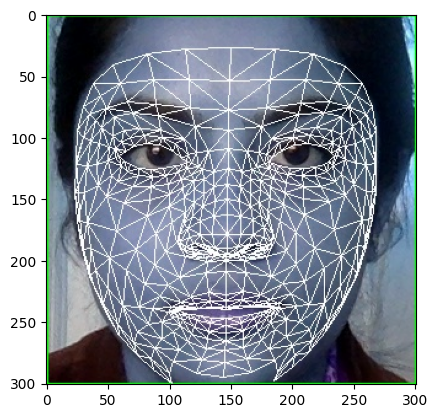

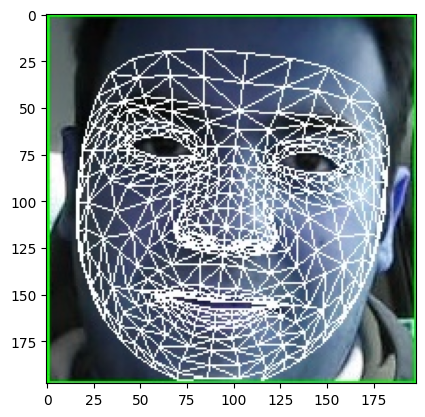

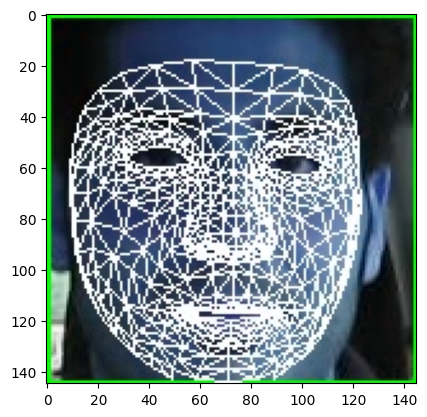

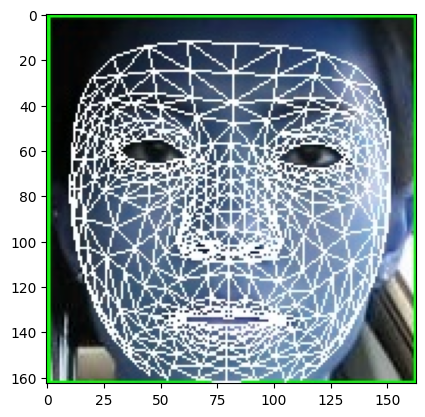

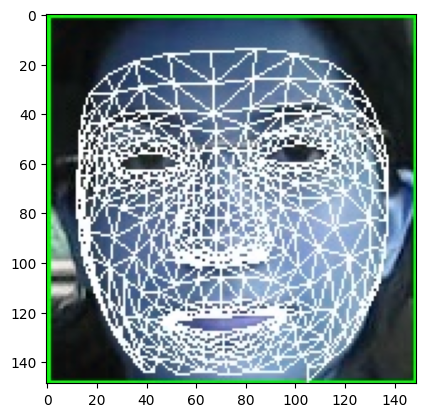

In [46]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages/{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages/{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

In [47]:
import os
import time
def face_for_yawn(direc="../datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1/0 FaceImages/"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [49]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

In [50]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [52]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

In [53]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [54]:
len(X_test)

3316

In [55]:
len(X_train)

13261

In [56]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [57]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [58]:
# Model Elsafty 1
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()
# Note the input shape is the desired size of the image 145 x 145 with 3 bytes color
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 143, 143, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 32)        12832     
                                                                 
 batch_normalization_1 (Bat  (None, 67, 67, 32)        128       
 chNormalization)                                                
                                                        

In [59]:
history = model.fit(train_generator, epochs=70, validation_data=test_generator)

Epoch 1/70
415/415 [==============================] - 270s 644ms/step - loss: 0.5020 - accuracy: 0.7444 - val_loss: 0.5062 - val_accuracy: 0.7117
Epoch 2/70
415/415 [==============================] - 243s 584ms/step - loss: 0.4310 - accuracy: 0.7803 - val_loss: 0.4645 - val_accuracy: 0.7651
Epoch 3/70
415/415 [==============================] - 243s 585ms/step - loss: 0.4041 - accuracy: 0.7960 - val_loss: 0.5295 - val_accuracy: 0.7262
Epoch 4/70
415/415 [==============================] - 238s 573ms/step - loss: 0.3802 - accuracy: 0.8111 - val_loss: 0.5801 - val_accuracy: 0.7129
Epoch 5/70
415/415 [==============================] - 236s 569ms/step - loss: 0.3595 - accuracy: 0.8267 - val_loss: 0.3704 - val_accuracy: 0.8115
Epoch 6/70
415/415 [==============================] - 235s 567ms/step - loss: 0.3400 - accuracy: 0.8384 - val_loss: 0.3945 - val_accuracy: 0.8272
Epoch 7/70
415/415 [==============================] - 242s 584ms/step - loss: 0.3194 - accuracy: 0.8499 - val_loss: 0.3028 -

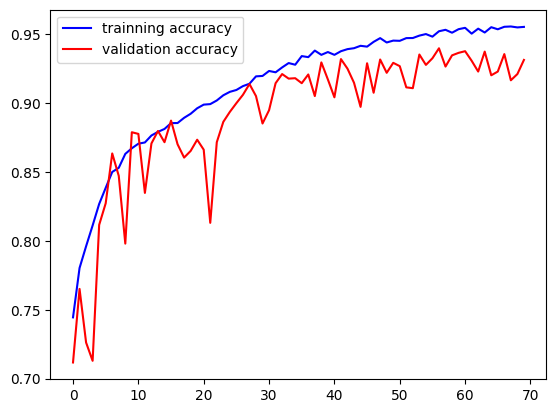

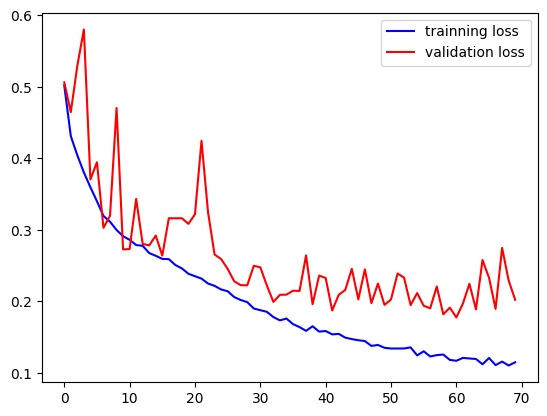

In [60]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [61]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
104/104 [==============================] - 9s 85ms/step - loss: 0.2021 - accuracy: 0.9312


{'loss': 0.2021484375, 'accuracy': 0.9312424659729004}

In [62]:
model.save('my_test_model.keras')

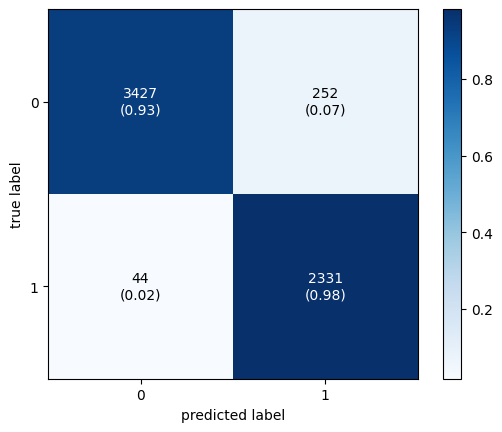

In [63]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [ ]:
#!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)

In [ ]:
#!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
keras2ascii(model)